# Lab-6.1: ARM (Bonus)

**Author**: J. Hickman

`THIS IS AN OPTIONAL (NOT MANDATORY) BONUS ASSIGNMENT FOR UP TO +7.5 BONUS POINTS` 

In this lab we will use sentiment analysis in association rule learning to analyze a novel (Dracula)


**Instructions** 

* Read and work through all tutorial content and do all exercises below
  
**Submission:**

* You need to upload ONE document to Canvas when you are done
  * (1) A PDF (or HTML) of the completed form of this notebook 
* The final uploaded version should NOT have any code-errors present 
* All outputs must be visible in the uploaded version, including code-cell outputs, images, graphs, etc

## Import 

In [69]:
import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from apyori import apriori
import networkx as nx 


In [70]:
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hannahkim/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hannahkim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hannahkim/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/hannahkim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/hannahkim/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## 6.1.1: Read and clean novel

* The following code is needed to read, clean, and convert the novel into a format suitable for ARM 
* Various chunks of code are missing, your job is to complete them based on the comments 


In [71]:
#USER PARAM
input_path			=	'DRACULA.txt'
compute_sentiment 	=	True		
sentiment    		=	[]			#average sentiment of each chunck of text 
ave_window_size		=	250			#size of scanning window for moving average
					

#OUTPUT FILE
output='transactions.txt'
if os.path.exists(output): os.remove(output)

#INITIALIZE
lemmatizer 	= 	WordNetLemmatizer()
ps 			=	PorterStemmer()
sia 		= 	SentimentIntensityAnalyzer()

#ADD MORE
stopwords	=	stopwords.words('english')
add=['mr','mrs','wa','dr','said','back','could','one','looked','like','know','around','dont']
for sp in add: stopwords.append(sp)

def read_and_clean(path,START=0,STOP=-1):
	global sentiment 

	#-----------------------
	#INSERT CODE TO READ IN AS ONE BIG STING
	file = open(input_path)
	text = file.read().lower()
	file.close()
	#-----------------------

	#REMOVE HEADER, AND NEW LINES
	text=text.replace("'",'') #wasn't --> wasnt
	lines = text.splitlines(); text=''; 
	lines=lines[START:STOP]    # mystring.replace('\n', ' ')
	for line in lines: text=text+' '+line

	#-----------------------
	#INSERT CODE TO ONLY KEEP CHAR IN string.printable
	tmp = ''
	printable = set(string.printable)
	for char in text:
		if (char in printable): tmp = tmp + char
	txt = tmp
	#-----------------------

	#BREAK INTO CHUNKS (SENTANCES OR OTHERWISE)
	sentences=nltk.tokenize.sent_tokenize(text)  #SENTENCES

	print("NUMBER OF SENTENCES FOUND:",len(sentences)); #print(sentences)

	#CLEAN AND LEMMATIZE
	keep='0123456789abcdefghijklmnopqrstuvwxy';

	new_sentences=[]; vocabulary=[]
	for sentence in sentences:
		new_sentence=''

		# REBUILD LEMITIZED SENTENCE
		for word in sentence.split():
			
			#ONLY KEEP CHAR IN "keep"
			tmp2=''
			for char in word: 
				if(char in keep): 
					tmp2=tmp2+char
				else:
					tmp2=tmp2+' '
			word=tmp2

			#-----------------------
			# INSERT CODE TO LEMMATIZE THE WORDS
			new_word = lemmatizer.lemmatize(word)
			#-----------------------

			#REMOVE WHITE SPACES
			new_word=new_word.replace(' ', '')

			#BUILD NEW SENTANCE BACK UP
			if( new_word not in stopwords):
				if(new_sentence==''):
					new_sentence=new_word
				else:
					new_sentence=new_sentence+','+new_word
				if(new_word not in vocabulary): vocabulary.append(new_word)

		#SAVE (LIST OF LISTS)		
		new_sentences.append(new_sentence.split(","))
		
		#SIA
		if(compute_sentiment):
			#-----------------------
			# INSERT CODE TO USE NLTK TO DO SENTIMENT ANALYSIS 
			text1 = new_sentence.replace(",", " ")
			score = sia.polarity_scores(text1)
			sentiment.append([score['neg'], score['pos']])
			#-----------------------
			
		#SAVE SENTANCE TO OUTPUT FILE
		if(len(new_sentence.split(','))>2):
			f = open(output, "a")
			f.write(new_sentence+"\n")
			f.close()

	sentiment=np.array(sentiment)
	print("TOTAL AVERAGE SENTEMENT:",np.mean(sentiment,axis=0))
	print("VOCAB LENGTH",len(vocabulary))
	return new_sentences

transactions=read_and_clean(input_path,400,-400)
print(transactions[0:5])


NUMBER OF SENTENCES FOUND: 8295
TOTAL AVERAGE SENTEMENT: [0.12367703 0.17748403]
VOCAB LENGTH 9791
[['grim', 'fancy', 'engendered', 'earlier', 'evening', 'falling', 'sunset', 'threw', 'strange', 'relief', 'ghostlike', 'cloud', 'amongst', 'carpathians', 'seem', 'wind', 'ceaselessly', 'valleys'], ['sometimes', 'hill', 'steep', 'despite', 'driver', 'haste', 'horse', 'go', 'slowly'], ['wished', 'get', 'walk', 'home', 'driver', 'would', 'hear'], ['must', 'walk', 'dog', 'fierce', 'added', 'evidently', 'meant', 'grim', 'pleasantryfor', 'round', 'catch', 'approving', 'smile', 'restand', 'may', 'enough', 'matter', 'go', 'sleep'], ['stop', 'would', 'make', 'moment', 'pause', 'light', 'lamps']]


In [73]:
sentiment = pd.DataFrame(sentiment)
sentiment.columns = ['neg', 'pos']

## 

## 6.1.2: Visualize sentiment 

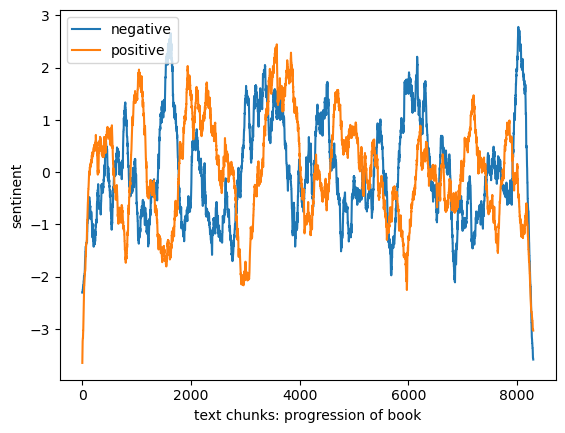

In [74]:

def moving_ave(y,w=100):
	#-----------------------
	# INSERT CODE TO COMPUTE THE MOVING AVERAGE OF A SIGNAL Y
	mask = np.ones((1,w))/w
	mask = mask[0,:]
	return np.convolve(y,mask,'same')
	#-----------------------

# INSERT CODE TO VISUALIZE THE SENTIMENT ANALYSIS AS A TIME-SERIES (SEE PLOT FOR AN EXAMPLE)
if(compute_sentiment):
	neg = moving_ave(sentiment.iloc[:,0],ave_window_size)
	neg = (neg-np.mean(neg))/np.std(neg)

	pos=moving_ave(sentiment.iloc[:,1],ave_window_size)
	pos=(pos-np.mean(pos))/np.std(pos)

	indx = np.linspace(0,len(sentiment),len(sentiment))
	plt.plot(indx,neg, label="negative") 
	plt.plot(indx, pos, label= "positive")
	plt.legend (loc = "upper left")
	plt.xlabel("text chunks: progression of book") 
	plt.ylabel("sentinent")
	plt.show()

## Lab-6.1.3: Re-format output

In [75]:
# INSERT CODE TO RE-FORMAT THE APRIORI OUTPUT INTO A PANDAS DATA-FRAME WITH COLUMNS "rhs","lhs","supp","conf","supp x conf","lift"
def reformat_results(results):
    #CLEAN-UP RESULTS 
    keep=[]
    for i in range(0,len(results)):
        # print("=====================================")
        # print(results[i])
        # print(len(list(results[i])))
        for j in range(0,len(list(results[i]))):
            # print(results)
            if(j>1):
                for k in range(0,len(list(results[i][j]))):
                    if(len(results[i][j][k][0])!=0):
                        #print(len(results[i][j][k][0]),results[i][j][k][0])
                        rhs=list(results[i][j][k][0])
                        lhs=list(results[i][j][k][1])
                        conf=float(results[i][j][k][2])
                        lift=float(results[i][j][k][3])
                        keep.append([rhs,lhs,supp,conf,supp*conf,lift])
                        # keep.append()
            if(j==1):
                supp=results[i][j]

    return pd.DataFrame(keep, columns =["rhs","lhs","supp","conf","supp x conf","lift"])

## Utility function: Convert to NetworkX object

In [76]:
def convert_to_network(df):
    print(df)

    #BUILD GRAPH
    G = nx.DiGraph()  # DIRECTED
    for row in df.iterrows():
        # for column in df.columns:
        lhs="_".join(row[1][0])
        rhs="_".join(row[1][1])
        conf=row[1][3]; #print(conf)
        if(lhs not in G.nodes): 
            G.add_node(lhs)
        if(rhs not in G.nodes): 
            G.add_node(rhs)

        edge=(lhs,rhs)
        if edge not in G.edges:
            G.add_edge(lhs, rhs, weight=conf)

    # print(G.nodes)
    # print(G.edges)
    return G


## Utility function: Plot NetworkX object

In [77]:
def plot_network(G):
    #SPECIFIY X-Y POSITIONS FOR PLOTTING
    pos=nx.random_layout(G)

    #GENERATE PLOT
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 15)

    #assign colors based on attributes
    weights_e 	= [G[u][v]['weight'] for u,v in G.edges()]

    #SAMPLE CMAP FOR COLORS 
    cmap=plt.cm.get_cmap('Blues')
    colors_e 	= [cmap(G[u][v]['weight']*10) for u,v in G.edges()]

    #PLOT
    nx.draw(
    G,
    edgecolors="black",
    edge_color=colors_e,
    node_size=2000,
    linewidths=2,
    font_size=8,
    font_color="white",
    font_weight="bold",
    width=weights_e,
    with_labels=True,
    pos=pos,
    ax=ax
    )
    ax.set(title='Dracula')
    plt.show()

# raise

## 6.1.4: Train ARM model 

In [82]:
# INSERT CODE TO TRAIN THE ARM MODEL USING THE "apriori" PACKAGE
print("Transactions:",pd.DataFrame(transactions))
results = list(apriori(transactions, min_support=0.003, min_confidence=0.02, min_lift=1, min_length=2))     #RUN APRIORI ALGORITHM
print(len(results))

Transactions:              0        1           2         3         4          5         6   \
0          grim    fancy  engendered   earlier   evening    falling    sunset   
1     sometimes     hill       steep   despite    driver      haste     horse   
2        wished      get        walk      home    driver      would      hear   
3          must     walk         dog    fierce     added  evidently     meant   
4          stop    would        make    moment     pause      light     lamps   
...         ...      ...         ...       ...       ...        ...       ...   
8290       book     sure    wantsome  possibly    always     wanted      None   
8291   selected     list       every      book        ha   achieved   certain   
8292    grosset               dunlap      list  greatest      index      good   
8293        pay     look        side   wrapper      case    wrapper      lost   
8294        ask  grosset               dunlaps      list     secret  barbican   

             

## Lab-6.1.5: Visualize the results

              rhs            lhs      supp      conf  supp x conf       lift
0          [came]         [room]  0.003134  0.086957     0.000273   3.418504
1          [room]         [came]  0.003134  0.123223     0.000386   3.418504
2          [come]          [may]  0.003496  0.083333     0.000291   1.941713
3           [may]         [come]  0.003496  0.081461     0.000285   1.941713
4          [come]         [must]  0.003014  0.071839     0.000217   1.467747
..            ...            ...       ...       ...          ...        ...
75        [madam]   [mina, dear]  0.003014  0.280899     0.000847  70.607763
76         [mina]  [madam, dear]  0.003014  0.113636     0.000342  33.664773
77  [madam, dear]         [mina]  0.003014  0.892857     0.002691  33.664773
78   [mina, dear]        [madam]  0.003014  0.757576     0.002283  70.607763
79  [madam, mina]         [dear]  0.003014  0.312500     0.000942  12.583434

[80 rows x 6 columns]


/var/folders/1z/6nvrnkz13ms1y39fh2328y7m0000gn/T/ipykernel_63501/3607068954.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues')


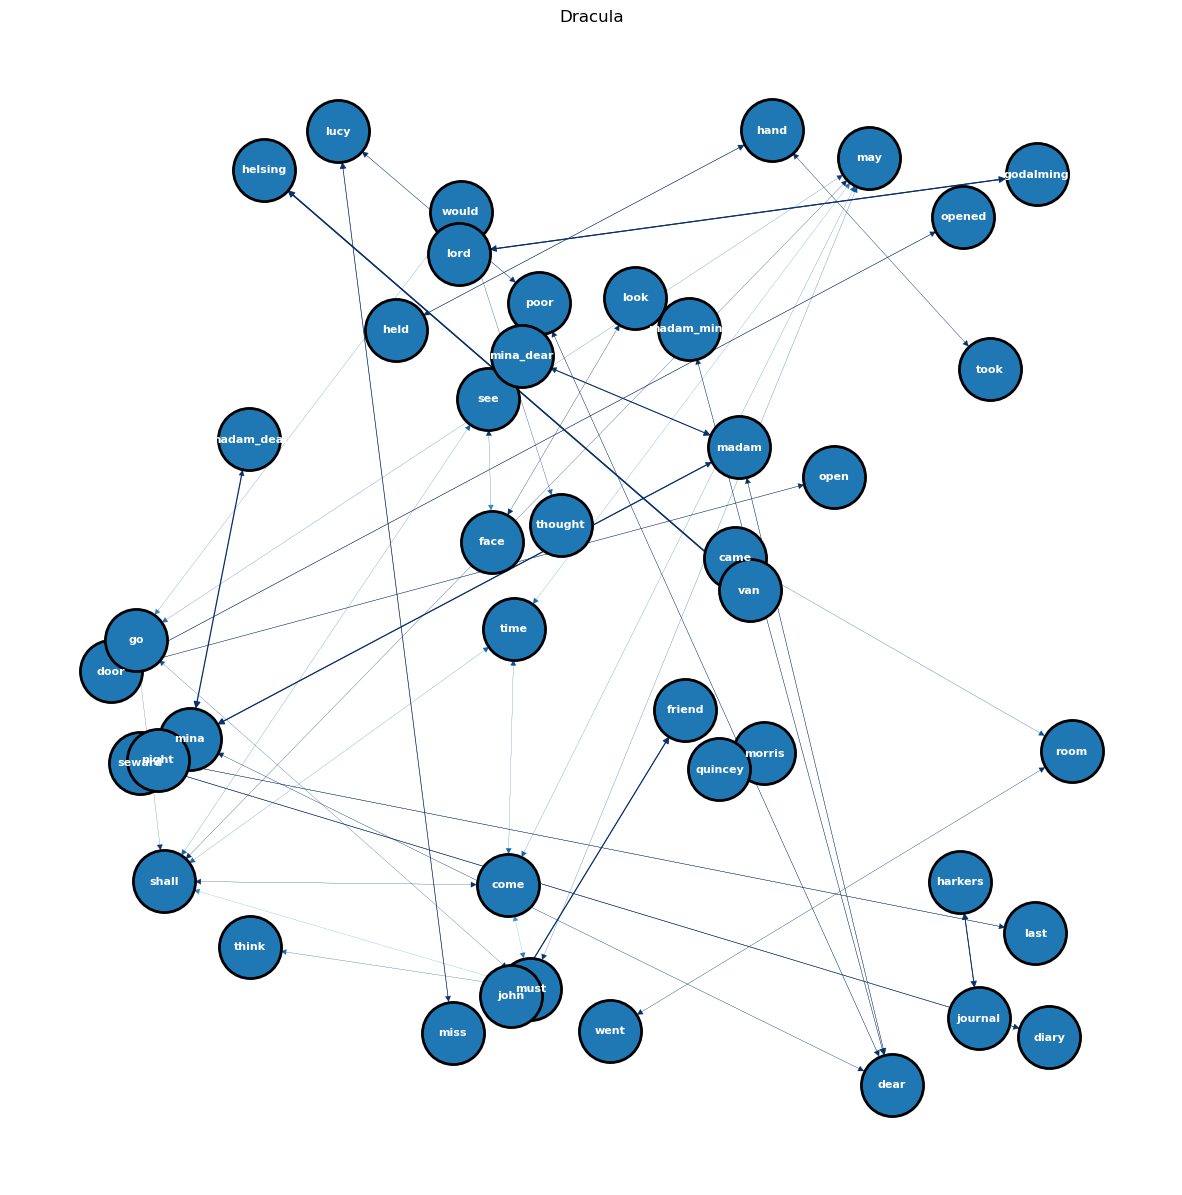

In [83]:
# INSERT CODE TO PLOT THE RESULTS AS A NETWORK-X OBJECT 
pd_results = reformat_results(results)
G = convert_to_network(pd_results)
plot_network(G)